# Cross-Package Validation

This notebook validates that tailestim produce identical results as [tail-estimation](https://github.com/ivanvoitalov/tail-estimation) across multiple estimators and datasets.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib.util

# Import tailestim
import tailestim
import os

# Import tail-estimation.py
# You need to clone it at the same level as this repository
# Use: git clone https://github.com/ivanvoitalov/tail-estimation
spec = importlib.util.spec_from_file_location("tail_estimation", os.path.abspath("../tail-estimation/Python3/tail-estimation.py"))
tail_estimation = importlib.util.module_from_spec(spec)
spec.loader.exec_module(tail_estimation)

In [22]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

## Load/Generate Test Data

- Synthetic data (Pareto with gamma = 2.5)
- `CAIDA_KONECT`
- `Libimseti_in_KONECT`
- `Pareto` (from Examples, gamma=2.5)

In [32]:
# Set random seed for reproducibility
seed = 42
np.random.seed(seed)

# Generate Pareto data with tail index gamma = 2.5
true_gamma = 2.5
n_samples = 5000
pareto_data = (np.random.pareto(true_gamma - 1, n_samples) + 1)

print(f"Generated {n_samples} samples from Pareto distribution")
print(f"True tail index: {true_gamma}")
print(f"Data range: [{pareto_data.min():.4f}, {pareto_data.max():.4f}]")

# Load real datasets
from tailestim.datasets import TailData

# Load CAIDA dataset
caida_data = TailData(name="CAIDA_KONECT").data
print(f"\nLoaded CAIDA_KONECT: {len(caida_data)} samples")
print(f"Data range: [{caida_data.min():.4f}, {caida_data.max():.4f}]")

# Load Libimseti dataset
libimseti_data = TailData(name="Libimseti_in_KONECT").data
print(f"\nLoaded Libimseti_in_KONECT: {len(libimseti_data)} samples")
print(f"Data range: [{libimseti_data.min():.4f}, {libimseti_data.max():.4f}]")

# Load Pareto dataset from examples
pareto_example_data = TailData(name="Pareto").data
print(f"\nLoaded Pareto: {len(pareto_example_data)} samples")
print(f"Data range: [{pareto_example_data.min():.4f}, {pareto_example_data.max():.4f}]")

# Store all datasets
datasets = {
    'Synthetic Pareto': pareto_data,
    'CAIDA_KONECT': caida_data,
    'Libimseti_in_KONECT': libimseti_data,
    'Pareto': pareto_example_data
}

# Use synthetic Pareto for detailed comparisons
data = pareto_data

Generated 5000 samples from Pareto distribution
True tail index: 2.5
Data range: [1.0000, 232.3621]

Loaded CAIDA_KONECT: 26475 samples
Data range: [1.0000, 2628.0000]

Loaded Libimseti_in_KONECT: 168791 samples
Data range: [1.0000, 33389.0000]

Loaded Pareto: 5000 samples
Data range: [1.0000, 425.1571]


## Hill Estimator Comparison

In [33]:
# Hill estimator - new (tailestim)
from tailestim.estimators import HillEstimator

print(f"Using data with {len(data)} samples for Hill estimator")

hill_new = HillEstimator(bootstrap=True, r_bootstrap=200, base_seed=42, verbose=False, diagn_plots=False)
hill_new.fit(data)
result_new = hill_new.get_result()
gamma_new_hill = result_new.gamma_
k_new_hill = result_new.k_star_

# Hill estimator - old (tail-estimation)
ordered_data_hill = np.sort(data)[::-1]
print(f"Ordered data length: {len(ordered_data_hill)}")

results_old_hill = tail_estimation.hill_estimator(
    ordered_data_hill, 
    bootstrap=True, 
    r_bootstrap=200,
    base_seed=42,
    verbose=False,
    diagn_plots=False
)
k_arr_old_hill, xi_arr_old_hill, k_star_old_hill, xi_star_old_hill = results_old_hill[:4]
gamma_old_hill = 1 + 1.0 / xi_star_old_hill

print("Hill Estimator Results:")
print(f"  tailestim (new):        γ = {gamma_new_hill:.6f}, k* = {k_new_hill}")
print(f"  tail-estimation (old):  γ = {gamma_old_hill:.6f}, k* = {k_star_old_hill}")
print(f"  Difference:             {abs(gamma_new_hill - gamma_old_hill):.10f}")
print(f"  Match: {np.allclose(gamma_new_hill, gamma_old_hill) and k_new_hill == k_star_old_hill}")

Using data with 5000 samples for Hill estimator
Ordered data length: 5000
Adjusted Hill estimated gamma: 2.5174723016199696
**********
Hill Estimator Results:
  tailestim (new):        γ = 2.517472, k* = 4983
  tail-estimation (old):  γ = 2.517472, k* = 4983
  Difference:             0.0000000000
  Match: True


## Kernel-Type Estimator Comparison

In [34]:
# Kernel-type estimator - new (tailestim)
from tailestim.estimators import KernelTypeEstimator

kernel_new = KernelTypeEstimator(
    hsteps=50,
    alpha=0.6,
    bootstrap=True,
    r_bootstrap=200,
    base_seed=88,
    verbose=False,
    diagn_plots=False
)
kernel_new.fit(data)
result_new = kernel_new.get_result()
gamma_new_kernel = result_new.gamma_
k_new_kernel = result_new.k_star_

# Kernel-type estimator - old (tail-estimation)
ordered_data_kernel = np.sort(data)[::-1]
results_old_kernel = tail_estimation.kernel_type_estimator(
    ordered_data_kernel,
    hsteps=50,
    alpha=0.6,
    bootstrap=True,
    r_bootstrap=200,
    base_seed=88
)
k_arr_old_kernel, xi_arr_old_kernel, k_star_old_kernel, xi_star_old_kernel = results_old_kernel[:4]
gamma_old_kernel = 1 + 1.0 / xi_star_old_kernel

print("Kernel-Type Estimator Results:")
print(f"  tailestim (new):        γ = {gamma_new_kernel:.6f}, k* = {k_new_kernel}")
print(f"  tail-estimation (old):  γ = {gamma_old_kernel:.6f}, k* = {k_star_old_kernel}")
print(f"  Difference:             {abs(gamma_new_kernel - gamma_old_kernel):.10f}")
print(f"  Match: {np.allclose(gamma_new_kernel, gamma_old_kernel) and k_new_kernel == k_star_old_kernel}")

Kernel-type estimated gamma: 2.5518702043480816
**********
Kernel-Type Estimator Results:
  tailestim (new):        γ = 2.551870, k* = 4201
  tail-estimation (old):  γ = 2.551870, k* = 4201
  Difference:             0.0000000000
  Match: True


## Pickands Estimator Comparison

In [35]:
# Pickands estimator - new (tailestim)
from tailestim.estimators import PickandsEstimator

pickands_new = PickandsEstimator()
pickands_new.fit(data)
result_new_pickands = pickands_new.get_result()

# Pickands estimator - old (tail-estimation)
ordered_data_pickands = np.sort(data)[::-1]
k_arr_old_pickands, xi_arr_old_pickands = tail_estimation.pickands_estimator(ordered_data_pickands)

# Compare arrays
pickands_k_match = np.allclose(result_new_pickands.k_arr_, k_arr_old_pickands)
pickands_xi_match = np.allclose(result_new_pickands.xi_arr_, xi_arr_old_pickands)

print("Pickands Estimator Results:")
print(f"  k_arr match: {pickands_k_match}")
print(f"  xi_arr match: {pickands_xi_match}")
print(f"  Array lengths - new: {len(result_new_pickands.k_arr_)}, old: {len(k_arr_old_pickands)}")
if not pickands_k_match:
    print(f"  Max k difference: {np.max(np.abs(result_new_pickands.k_arr_ - k_arr_old_pickands)):.2e}")
if not pickands_xi_match:
    print(f"  Max xi difference: {np.max(np.abs(result_new_pickands.xi_arr_ - xi_arr_old_pickands)):.2e}")

Pickands Estimator Results:
  k_arr match: True
  xi_arr match: True
  Array lengths - new: 1250, old: 1250


## Moments Estimator Comparison

In [36]:
# Moments estimator - new (tailestim)
from tailestim.estimators import MomentsEstimator

moments_new = MomentsEstimator(bootstrap=True, r_bootstrap=200, base_seed=99)
moments_new.fit(data)
result_new = moments_new.get_result()
gamma_new_moments = result_new.gamma_
k_new_moments = result_new.k_star_

# Moments estimator - old (tail-estimation)
ordered_data_moments = np.sort(data)[::-1]
results_old_moments = tail_estimation.moments_estimator(
    ordered_data_moments,
    bootstrap=True,
    r_bootstrap=200,
    base_seed=99
)
k_arr_old_moments, xi_arr_old_moments, k_star_old_moments, xi_star_old_moments = results_old_moments[:4]
gamma_old_moments = 1 + 1.0 / xi_star_old_moments

print("Moments Estimator Results:")
print(f"  tailestim (new):        γ = {gamma_new_moments:.6f}, k* = {k_new_moments}")
print(f"  tail-estimation (old):  γ = {gamma_old_moments:.6f}, k* = {k_star_old_moments}")
print(f"  Difference:             {abs(gamma_new_moments - gamma_old_moments):.10f}")
print(f"  Match: {np.allclose(gamma_new_moments, gamma_old_moments) and k_new_moments == k_star_old_moments}")

Moments estimated gamma: 2.5285706539255854
**********
Moments Estimator Results:
  tailestim (new):        γ = 2.528571, k* = 4531
  tail-estimation (old):  γ = 2.528571, k* = 4531
  Difference:             0.0000000000
  Match: True


## Visual Comparison: Hill Plot

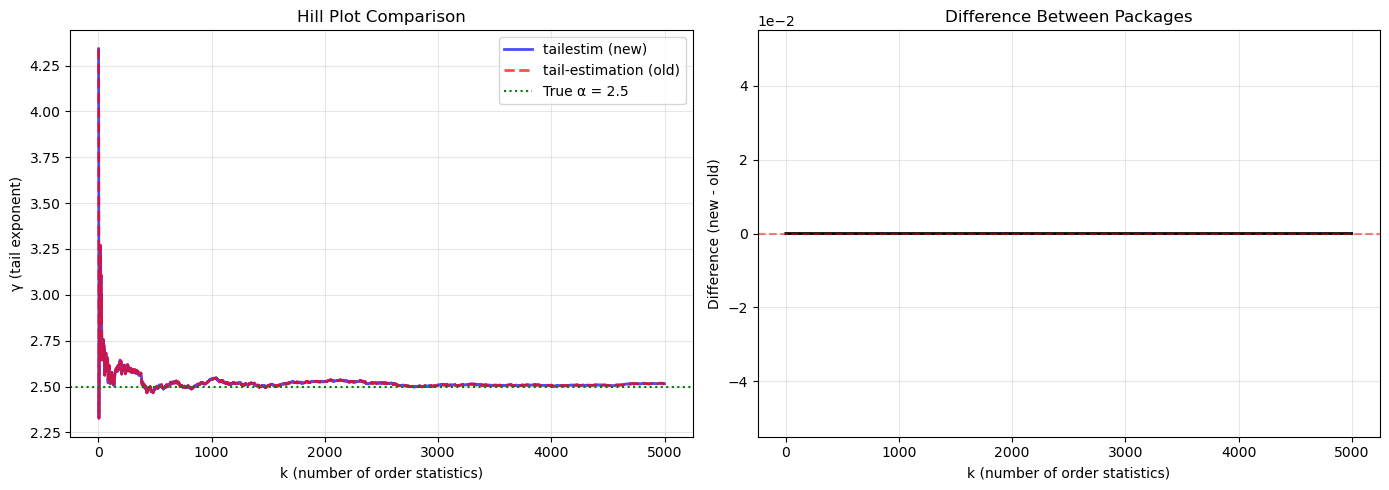


Max absolute difference in Hill estimates: 0.00e+00
Mean absolute difference: 0.00e+00


In [37]:
# Generate Hill plot data for both packages
from tailestim.estimators import HillEstimator

# Get full arrays from both implementations
# New (tailestim)
hill_new_plot = HillEstimator(bootstrap=False)
hill_new_plot.fit(data)
result_new_plot = hill_new_plot.get_result()

# Old (tail-estimation)
ordered_data_plot = np.sort(data)[::-1]
results_old_plot = tail_estimation.hill_estimator(ordered_data_plot, bootstrap=False)
k_arr_old_plot, xi_arr_old_plot = results_old_plot[:2]

# Convert xi to gamma (γ = 1 + 1/ξ)
gamma_arr_new = 1 + 1.0 / result_new_plot.xi_arr_
gamma_arr_old = 1 + 1.0 / xi_arr_old_plot

# Use k arrays from both
k_arr_new = result_new_plot.k_arr_

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Hill plot overlay
ax1.plot(k_arr_new, gamma_arr_new, 'b-', label='tailestim (new)', alpha=0.7, linewidth=2)
ax1.plot(k_arr_old_plot, gamma_arr_old, 'r--', label='tail-estimation (old)', alpha=0.7, linewidth=2)
ax1.axhline(y=true_gamma, color='g', linestyle=':', label=f'True α = {true_gamma}')
ax1.set_xlabel('k (number of order statistics)')
ax1.set_ylabel('γ (tail exponent)')
ax1.set_title('Hill Plot Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Difference plot
differences = gamma_arr_new - gamma_arr_old
ax2.plot(k_arr_new, differences, 'k-', linewidth=2)
ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax2.set_xlabel('k (number of order statistics)')
ax2.set_ylabel('Difference (new - old)')
ax2.set_title('Difference Between Packages')
ax2.grid(True, alpha=0.3)
ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.show()

print(f"\nMax absolute difference in Hill estimates: {np.max(np.abs(differences)):.2e}")
print(f"Mean absolute difference: {np.mean(np.abs(differences)):.2e}")

## Multi-Dataset Validation

In [38]:
# Test all estimators on all datasets - comparing both packages
from tailestim.estimators import HillEstimator, MomentsEstimator, KernelTypeEstimator
import pandas as pd

comparison_results = []

for dataset_name, dataset in datasets.items():
    print(f"\n{'='*80}")
    print(f"Dataset: {dataset_name}")
    print(f"Size: {len(dataset)}, Range: [{dataset.min():.2f}, {dataset.max():.2f}]")
    print(f"{'='*80}\n")
    
    seed = 42
    ordered_data = np.sort(dataset)[::-1]
    
    # Hill Estimator
    print("Hill Estimator:")
    hill_new = HillEstimator(bootstrap=True, r_bootstrap=100, base_seed=seed, verbose=False, diagn_plots=False)
    hill_new.fit(dataset)
    hill_result_new = hill_new.get_result()
    
    results_old_hill = tail_estimation.hill_estimator(
        ordered_data, bootstrap=True, r_bootstrap=100, base_seed=seed, verbose=False, diagn_plots=False
    )
    _, _, k_star_old_hill, xi_star_old_hill = results_old_hill[:4]
    gamma_old_hill = 1 + 1.0 / xi_star_old_hill
    
    print(f"  tailestim (new):        γ = {hill_result_new.gamma_:.6f}, k* = {hill_result_new.k_star_}")
    print(f"  tail-estimation (old):  γ = {gamma_old_hill:.6f}, k* = {k_star_old_hill}")
    print(f"  Match: {np.allclose(hill_result_new.gamma_, gamma_old_hill) and hill_result_new.k_star_ == k_star_old_hill}")
    
    # Moments Estimator
    print("\nMoments Estimator:")
    moments_new = MomentsEstimator(bootstrap=True, r_bootstrap=100, base_seed=seed, verbose=False, diagn_plots=False)
    moments_new.fit(dataset)
    moments_result_new = moments_new.get_result()
    
    results_old_moments = tail_estimation.moments_estimator(
        ordered_data, bootstrap=True, r_bootstrap=100, base_seed=seed
    )
    _, _, k_star_old_moments, xi_star_old_moments = results_old_moments[:4]
    gamma_old_moments = 1 + 1.0 / xi_star_old_moments
    
    print(f"  tailestim (new):        γ = {moments_result_new.gamma_:.6f}, k* = {moments_result_new.k_star_}")
    print(f"  tail-estimation (old):  γ = {gamma_old_moments:.6f}, k* = {k_star_old_moments}")
    print(f"  Match: {np.allclose(moments_result_new.gamma_, gamma_old_moments) and moments_result_new.k_star_ == k_star_old_moments}")
    
    # Kernel Estimator
    print("\nKernel-Type Estimator:")
    kernel_new = KernelTypeEstimator(bootstrap=True, r_bootstrap=100, hsteps=50, base_seed=seed, verbose=False, diagn_plots=False)
    kernel_new.fit(dataset)
    kernel_result_new = kernel_new.get_result()
    
    results_old_kernel = tail_estimation.kernel_type_estimator(
        ordered_data, hsteps=50, bootstrap=True, r_bootstrap=100, base_seed=seed
    )
    _, _, k_star_old_kernel, xi_star_old_kernel = results_old_kernel[:4]
    gamma_old_kernel = 1 + 1.0 / xi_star_old_kernel
    
    print(f"  tailestim (new):        γ = {kernel_result_new.gamma_:.6f}, k* = {kernel_result_new.k_star_}")
    print(f"  tail-estimation (old):  γ = {gamma_old_kernel:.6f}, k* = {k_star_old_kernel}")
    print(f"  Match: {np.allclose(kernel_result_new.gamma_, gamma_old_kernel) and kernel_result_new.k_star_ == k_star_old_kernel}")
    
    # Store results
    comparison_results.append({
        'Dataset': dataset_name,
        'Hill (new)': f"{hill_result_new.gamma_:.4f}",
        'Hill (old)': f"{gamma_old_hill:.4f}",
        'Hill Match': '✓' if (np.allclose(hill_result_new.gamma_, gamma_old_hill) and hill_result_new.k_star_ == k_star_old_hill) else '✗',
        'Moments (new)': f"{moments_result_new.gamma_:.4f}",
        'Moments (old)': f"{gamma_old_moments:.4f}",
        'Moments Match': '✓' if (np.allclose(moments_result_new.gamma_, gamma_old_moments) and moments_result_new.k_star_ == k_star_old_moments) else '✗',
        'Kernel (new)': f"{kernel_result_new.gamma_:.4f}",
        'Kernel (old)': f"{gamma_old_kernel:.4f}",
        'Kernel Match': '✓' if (np.allclose(kernel_result_new.gamma_, gamma_old_kernel) and kernel_result_new.k_star_ == k_star_old_kernel) else '✗',
    })

# Display comparison table
print(f"\n{'='*80}")
print("MULTI-DATASET COMPARISON SUMMARY")
print(f"{'='*80}\n")

df = pd.DataFrame(comparison_results)
print(df.to_string(index=False))


Dataset: Synthetic Pareto
Size: 5000, Range: [1.00, 232.36]

Hill Estimator:
Adjusted Hill estimated gamma: 2.5155731249786175
**********
  tailestim (new):        γ = 2.515573, k* = 4931
  tail-estimation (old):  γ = 2.515573, k* = 4931
  Match: True

Moments Estimator:
Moments estimated gamma: 2.5291026115858877
**********
  tailestim (new):        γ = 2.529103, k* = 4532
  tail-estimation (old):  γ = 2.529103, k* = 4532
  Match: True

Kernel-Type Estimator:
Kernel-type estimated gamma: 2.5518702043480816
**********
  tailestim (new):        γ = 2.551870, k* = 4201
  tail-estimation (old):  γ = 2.551870, k* = 4201
  Match: True

Dataset: CAIDA_KONECT
Size: 26475, Range: [1.00, 2628.00]

Hill Estimator:
Adjusted Hill estimated gamma: 2.305441888716154
**********
  tailestim (new):        γ = 2.305442, k* = 22909
  tail-estimation (old):  γ = 2.305442, k* = 22909
  Match: True

Moments Estimator:
Moments estimated gamma: 2.281601296431142
**********
  tailestim (new):        γ = 2.281

## Summary Comparison Table

In [39]:
import pandas as pd

# RE-RUN ALL COMPARISONS WITH FRESH DATA TO ENSURE CORRECTNESS
print("="*80)
print("DETAILED DIAGNOSTICS (Synthetic Pareto)")
print("="*80)
print(f"\nRe-running all estimators on synthetic Pareto data ({len(data)} samples)")
print("="*80)

from tailestim.estimators import HillEstimator, MomentsEstimator, KernelTypeEstimator, PickandsEstimator

# Hill Estimator
print("\n[1/4] Running Hill Estimator...")
hill_new_final = HillEstimator(bootstrap=True, r_bootstrap=200, base_seed=42, verbose=False, diagn_plots=False)
hill_new_final.fit(data)
result_new_hill = hill_new_final.get_result()

ordered_data_hill_final = np.sort(data)[::-1]
results_old_hill_final = tail_estimation.hill_estimator(
    ordered_data_hill_final, bootstrap=True, r_bootstrap=200, base_seed=42, verbose=False, diagn_plots=False
)
k_arr_old_hill_f, xi_arr_old_hill_f, k_star_old_hill_f, xi_star_old_hill_f = results_old_hill_final[:4]
gamma_old_hill_f = 1 + 1.0 / xi_star_old_hill_f

print(f"  Data length used: {len(ordered_data_hill_final)}")
print(f"  k_arr match: {np.allclose(result_new_hill.k_arr_, k_arr_old_hill_f)}")
print(f"  xi_arr match: {np.allclose(result_new_hill.xi_arr_, xi_arr_old_hill_f)}")
print(f"  gamma match: {np.allclose(result_new_hill.gamma_, gamma_old_hill_f)}")
print(f"  k* match: {result_new_hill.k_star_ == k_star_old_hill_f}")
print(f"  xi* match: {np.allclose(result_new_hill.xi_star_, xi_star_old_hill_f)}")

# Moments Estimator  
print("\n[2/4] Running Moments Estimator...")
moments_new_final = MomentsEstimator(bootstrap=True, r_bootstrap=200, base_seed=99)
moments_new_final.fit(data)
result_new_moments = moments_new_final.get_result()

ordered_data_moments_final = np.sort(data)[::-1]
results_old_moments_final = tail_estimation.moments_estimator(
    ordered_data_moments_final, bootstrap=True, r_bootstrap=200, base_seed=99
)
k_arr_old_moments_f, xi_arr_old_moments_f, k_star_old_moments_f, xi_star_old_moments_f = results_old_moments_final[:4]
gamma_old_moments_f = 1 + 1.0 / xi_star_old_moments_f

print(f"  Data length used: {len(ordered_data_moments_final)}")
print(f"  gamma match: {np.allclose(result_new_moments.gamma_, gamma_old_moments_f)}")
print(f"  k* match: {result_new_moments.k_star_ == k_star_old_moments_f}")
print(f"  xi* match: {np.allclose(result_new_moments.xi_star_, xi_star_old_moments_f)}")

# Kernel Estimator
print("\n[3/4] Running Kernel Estimator...")
kernel_new_final = KernelTypeEstimator(
    hsteps=50, alpha=0.6, bootstrap=True, r_bootstrap=200, base_seed=88, verbose=False, diagn_plots=False
)
kernel_new_final.fit(data)
result_new_kernel = kernel_new_final.get_result()

ordered_data_kernel_final = np.sort(data)[::-1]
results_old_kernel_final = tail_estimation.kernel_type_estimator(
    ordered_data_kernel_final, hsteps=50, alpha=0.6, bootstrap=True, r_bootstrap=200, base_seed=88
)
k_arr_old_kernel_f, xi_arr_old_kernel_f, k_star_old_kernel_f, xi_star_old_kernel_f = results_old_kernel_final[:4]
gamma_old_kernel_f = 1 + 1.0 / xi_star_old_kernel_f

print(f"  Data length used: {len(ordered_data_kernel_final)}")
print(f"  gamma match: {np.allclose(result_new_kernel.gamma_, gamma_old_kernel_f)}")
print(f"  k* match: {result_new_kernel.k_star_ == k_star_old_kernel_f}")
print(f"  xi* match: {np.allclose(result_new_kernel.xi_star_, xi_star_old_kernel_f)}")

# Pickands Estimator
print("\n[4/4] Running Pickands Estimator...")
pickands_new_final = PickandsEstimator()
pickands_new_final.fit(data)
result_new_pickands = pickands_new_final.get_result()

ordered_data_pickands_final = np.sort(data)[::-1]
k_arr_old_pickands_f, xi_arr_old_pickands_f = tail_estimation.pickands_estimator(ordered_data_pickands_final)

pickands_k_match_f = np.allclose(result_new_pickands.k_arr_, k_arr_old_pickands_f)
pickands_xi_match_f = np.allclose(result_new_pickands.xi_arr_, xi_arr_old_pickands_f)

print(f"  Data length used: {len(ordered_data_pickands_final)}")
print(f"  k_arr match: {pickands_k_match_f}")
print(f"  xi_arr match: {pickands_xi_match_f}")

# Summary Table
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)

summary = pd.DataFrame({
    'Estimator': ['Hill', 'Kernel', 'Moments', 'Pickands'],
    'tailestim (new)': [
        f"{result_new_hill.gamma_:.6f} (k*={result_new_hill.k_star_})",
        f"{result_new_kernel.gamma_:.6f} (k*={result_new_kernel.k_star_})",
        f"{result_new_moments.gamma_:.6f} (k*={result_new_moments.k_star_})",
        "Arrays only"
    ],
    'tail-estimation (old)': [
        f"{gamma_old_hill_f:.6f} (k*={k_star_old_hill_f})",
        f"{gamma_old_kernel_f:.6f} (k*={k_star_old_kernel_f})",
        f"{gamma_old_moments_f:.6f} (k*={k_star_old_moments_f})",
        "Arrays only"
    ],
    'Match': [
        '✓' if (np.allclose(result_new_hill.gamma_, gamma_old_hill_f) and result_new_hill.k_star_ == k_star_old_hill_f) else '✗',
        '✓' if (np.allclose(result_new_kernel.gamma_, gamma_old_kernel_f) and result_new_kernel.k_star_ == k_star_old_kernel_f) else '✗',
        '✓' if (np.allclose(result_new_moments.gamma_, gamma_old_moments_f) and result_new_moments.k_star_ == k_star_old_moments_f) else '✗',
        '✓' if (pickands_k_match_f and pickands_xi_match_f) else '✗'
    ]
})

print(summary.to_string(index=False))
print("\n" + "="*80)

# Check all conditions
hill_match = np.allclose(result_new_hill.gamma_, gamma_old_hill_f) and result_new_hill.k_star_ == k_star_old_hill_f
kernel_match = np.allclose(result_new_kernel.gamma_, gamma_old_kernel_f) and result_new_kernel.k_star_ == k_star_old_kernel_f
moments_match = np.allclose(result_new_moments.gamma_, gamma_old_moments_f) and result_new_moments.k_star_ == k_star_old_moments_f
pickands_match = pickands_k_match_f and pickands_xi_match_f

all_match = hill_match and kernel_match and moments_match and pickands_match

if all_match:
    print("VALIDATION PASSED: All estimators produce identical results.")
else:
    print("VALIDATION FAILED: Some estimators produce different results.")
    if not hill_match:
        print(f"  - Hill estimator mismatch (k*: {result_new_hill.k_star_} vs {k_star_old_hill_f})")
    if not kernel_match:
        print(f"  - Kernel estimator mismatch (k*: {result_new_kernel.k_star_} vs {k_star_old_kernel_f})")
    if not moments_match:
        print(f"  - Moments estimator mismatch (k*: {result_new_moments.k_star_} vs {k_star_old_moments_f})")
    if not pickands_match:
        print("  - Pickands estimator mismatch")
print("="*80)

DETAILED DIAGNOSTICS (Synthetic Pareto)

Re-running all estimators on synthetic Pareto data (5000 samples)

[1/4] Running Hill Estimator...
Adjusted Hill estimated gamma: 2.5174723016199696
**********
  Data length used: 5000
  k_arr match: True
  xi_arr match: True
  gamma match: True
  k* match: True
  xi* match: True

[2/4] Running Moments Estimator...
Moments estimated gamma: 2.5285706539255854
**********
  Data length used: 5000
  gamma match: True
  k* match: True
  xi* match: True

[3/4] Running Kernel Estimator...
Kernel-type estimated gamma: 2.5518702043480816
**********
  Data length used: 5000
  gamma match: True
  k* match: True
  xi* match: True

[4/4] Running Pickands Estimator...
  Data length used: 5000
  k_arr match: True
  xi_arr match: True

SUMMARY TABLE
Estimator    tailestim (new) tail-estimation (old) Match
     Hill 2.517472 (k*=4983)    2.517472 (k*=4983)     ✓
   Kernel 2.551870 (k*=4201)    2.551870 (k*=4201)     ✓
  Moments 2.528571 (k*=4531)    2.528571 (k*